Loading and preprocessing data...
Dataset loaded: 6400 images, 2 classes
Class mapping: {0: 'Demented', 1: 'NonDem'}

Distributing data to 4 clients...
Client data distribution:
  Client 1: 1280 samples - Class distribution: {'Demented': 647, 'NonDem': 633}
  Client 2: 1280 samples - Class distribution: {'Demented': 621, 'NonDem': 659}
  Client 3: 1280 samples - Class distribution: {'Demented': 667, 'NonDem': 613}
  Client 4: 1280 samples - Class distribution: {'Demented': 625, 'NonDem': 655}

Global model architecture:


Model: "functional_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_86 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_288 (Conv2D)                  │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_243 (MaxPooling2D)     │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_289 (Conv2D)                  │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_244 (MaxPooling2D)     │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_290 (Conv2D)                  │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_245 (MaxPooling2D)     │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_81 (Flatten)                 │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_177 (Dense)                    │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_111 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_178 (Dense)                    │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,629,473 (6.22 MB)

 Trainable params: 1,629,473 (6.22 MB)

 Non-trainable params: 0 (0.00 B)


Starting federated learning for 16 rounds...

Federated Learning Round 1/16
  Training client 1...
    Client 1 training accuracy: 0.9977
  Training client 2...
    Client 2 training accuracy: 0.9969
  Training client 3...
    Client 3 training accuracy: 1.0000
  Training client 4...
    Client 4 training accuracy: 0.9680
  Round 1 - Global Model Metrics:
    Accuracy: 0.7727
    Client weights in aggregation: [0.252 0.252 0.252 0.244]

Federated Learning Round 2/16
  Training client 1...
    Client 1 training accuracy: 0.9992
  Training client 2...
    Client 2 training accuracy: 0.9953
  Training client 3...
    Client 3 training accuracy: 1.0000
  Training client 4...
    Client 4 training accuracy: 0.9984
  Round 2 - Global Model Metrics:
    Accuracy: 0.9258
    Client weights in aggregation: [0.25  0.249 0.25  0.25 ]

Federated Learning Round 3/16
  Training client 1...
    Client 1 training accuracy: 0.9977
  Training client 2...
    Client 2 training accuracy: 0.9961
  Trainin

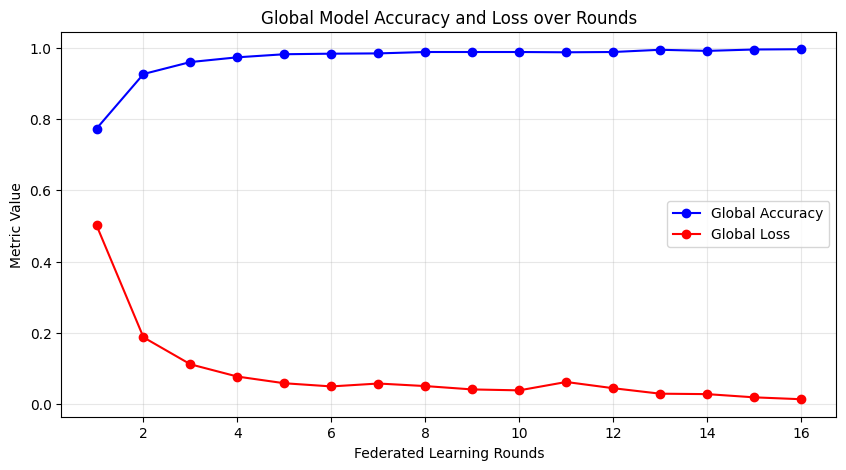

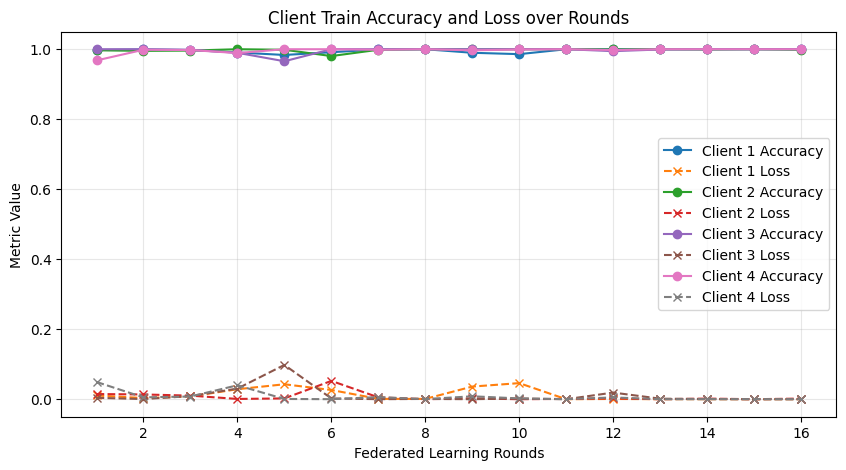

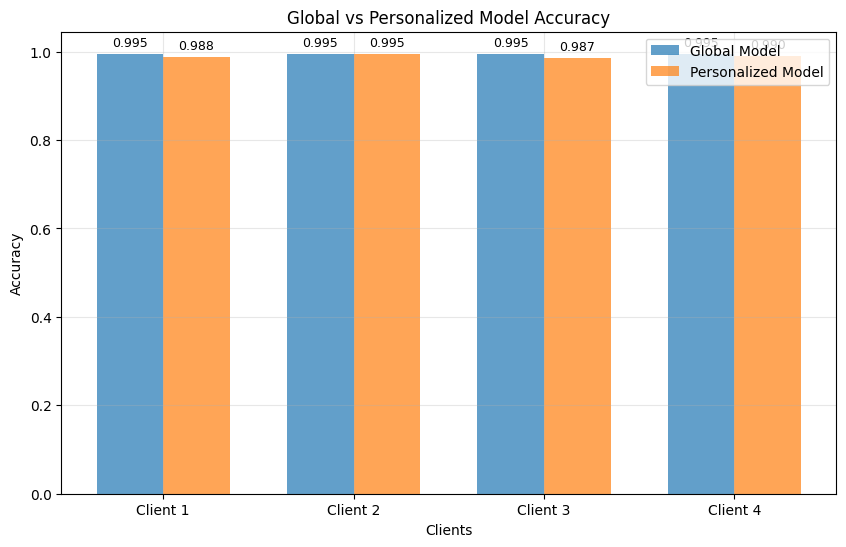

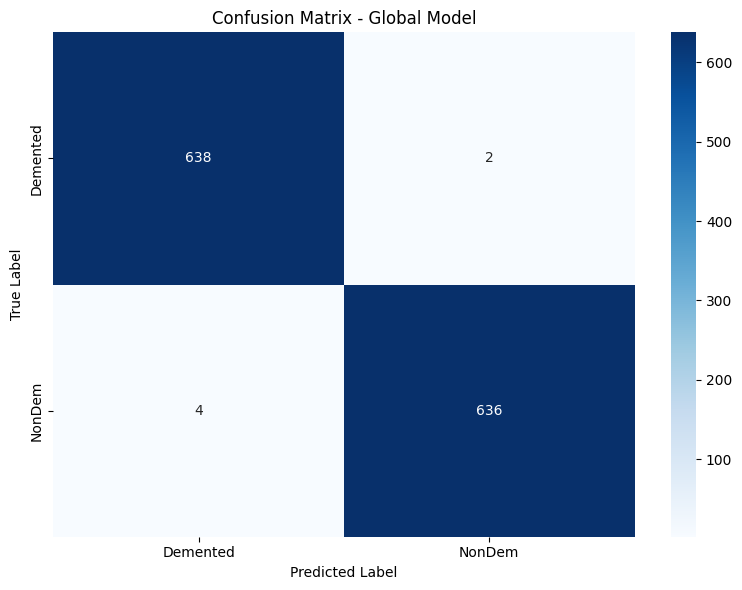


Classification Report:
              precision  recall  f1-score   support
Demented          0.994   0.997     0.995   640.000
NonDem            0.997   0.994     0.995   640.000
accuracy          0.995   0.995     0.995     0.995
macro avg         0.995   0.995     0.995  1280.000
weighted avg      0.995   0.995     0.995  1280.000

Federated learning completed!


In [7]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


#------------------------------------------------------------------------------
# Configuration Parameters
#------------------------------------------------------------------------------

# Dataset and model parameters
dataset_dir = '/kaggle/input/alz-dis/Alzheimer Disease'
IMG_SIZE = 128
BATCH_SIZE = 32 #16

# Federated learning parameters
EPOCHS = 32
NUM_ROUNDS = 16
NUM_CLIENTS = 4


#------------------------------------------------------------------------------
# 1. Data Loading and Preprocessing
#------------------------------------------------------------------------------

def load_images_and_labels(dataset_dir):
    """Load and preprocess images from the directory"""
    images, labels = [], []
    label_dict = {}
    
    for label, subfolder in enumerate(sorted(os.listdir(dataset_dir))):
        subfolder_path = os.path.join(dataset_dir, subfolder)
        label_dict[label] = subfolder
        
        if os.path.isdir(subfolder_path):
            for img_name in os.listdir(subfolder_path):
                if img_name.endswith(('.jpg', '.png')):
                    img_path = os.path.join(subfolder_path, img_name)
                    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                    img_array = image.img_to_array(img) / 255.0
                    images.append(img_array)
                    labels.append(label)
    
    return np.array(images), np.array(labels), label_dict


def distribute_data_to_clients(X, y, num_clients):
    """Distribute data to clients in a balanced way"""
    client_data = []
    client_labels = []
    
    # Split data into num_clients parts
    for i in range(num_clients):
        # Calculate indices for this client
        start_idx = i * len(X) // num_clients
        end_idx = (i + 1) * len(X) // num_clients
        
        client_data.append(X[start_idx:end_idx])
        client_labels.append(y[start_idx:end_idx])
    
    return client_data, client_labels


#------------------------------------------------------------------------------
# 2. Model Architecture
#------------------------------------------------------------------------------

def create_cnn_model():
    """Create a CNN model for binary classification using the functional API"""
    # Input layer
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Convolutional layers
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(2, 2)(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    
    # Fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


#------------------------------------------------------------------------------
# 3. Federated Learning Components
#------------------------------------------------------------------------------

def adaptive_federated_average(models, client_performances):
    """
    NOVEL COMPONENT 1: Adaptive federated averaging that weighs clients based on 
    their performance.
    
    Args:
        models: List of client models
        client_performances: List of client training accuracies
        
    Returns:
        avg_weights: Aggregated model weights
        weights: Client contribution weights
    """
    # Convert to numpy array and handle any problematic values
    client_performances = np.array(client_performances)
    client_performances = np.nan_to_num(client_performances, nan=0.1)
    client_performances = np.maximum(client_performances, 0.1)
    
    # Weight clients by their performance
    weights = client_performances / np.sum(client_performances)
    
    # Weighted average of model weights
    all_weights = [model.get_weights() for model in models]
    avg_weights = []
    
    for layer_weights in zip(*all_weights):
        stacked_weights = np.stack(layer_weights, axis=0)
        weighted_avg = np.average(stacked_weights, axis=0, weights=weights)
        avg_weights.append(weighted_avg)
    
    return avg_weights, weights


def personalize_model(global_model, client_data, client_labels):
    """
    NOVEL COMPONENT 2: Create a personalized model for each client by fine-tuning
    the global model on local data.
    
    Args:
        global_model: The trained global model
        client_data: Client's local data
        client_labels: Client's local labels
        
    Returns:
        Personalized model for the client
    """
    # Clone the global model
    personalized_model = clone_model(global_model)
    personalized_model.set_weights(global_model.get_weights())
    
    # Compile with a lower learning rate for fine-tuning
    personalized_model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Fine-tune on client data
    personalized_model.fit(
        client_data, client_labels,
        epochs=2,  # Fewer epochs for fine-tuning
        batch_size=BATCH_SIZE,
        verbose=0
    )
    
    return personalized_model


#------------------------------------------------------------------------------
# 4. Evaluation Functions
#------------------------------------------------------------------------------

def evaluate_model(model, X_test, y_test):
    """Comprehensive model evaluation with multiple metrics"""
    # Get predictions
    y_prob = model.predict(X_test, verbose=0)
    y_pred = (y_prob > 0.5).astype("int32")
    
    # Basic metrics
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Advanced metrics
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(
        y_test, y_pred, 
        target_names=[f'Class {i}' for i in range(len(np.unique(y_test)))], 
        output_dict=True
    )
    
    return {
        'accuracy': accuracy,
        'loss': loss,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'classification_report': report
    }


#------------------------------------------------------------------------------
# 5. Federated Learning Training Loop
#------------------------------------------------------------------------------

def train_federated_learning_model():
    """Main function to run the federated learning process"""
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # 1. Load and preprocess data
    print("Loading and preprocessing data...")
    images, labels, label_dict = load_images_and_labels(dataset_dir)
    print(f"Dataset loaded: {len(images)} images, {len(np.unique(labels))} classes")
    print(f"Class mapping: {label_dict}")
    
    # 2. Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, stratify=labels, random_state=42
    )
    
    # 3. Distribute data to clients
    print(f"\nDistributing data to {NUM_CLIENTS} clients...")
    client_data, client_labels = distribute_data_to_clients(X_train, y_train, NUM_CLIENTS)
    
    # Print data distribution
    print("Client data distribution:")
    for i, (data, labels) in enumerate(zip(client_data, client_labels)):
        unique, counts = np.unique(labels, return_counts=True)
        dist = {label_dict[int(u)]: c for u, c in zip(unique, counts)}
        print(f"  Client {i+1}: {len(data)} samples - Class distribution: {dist}")
    
    # 4. Initialize global model
    global_model = create_cnn_model()
    print("\nGlobal model architecture:")
    global_model.summary()
    
    # 5. Track training history
    history = {'global_accuracy': [], 'global_loss': []}
    client_histories = [{'accuracy': [], 'loss': []} for _ in range(NUM_CLIENTS)]
    client_weights_history = []
    
    # 6. Federated learning rounds
    print(f"\nStarting federated learning for {NUM_ROUNDS} rounds...")
    for round_num in range(NUM_ROUNDS):
        print(f"\nFederated Learning Round {round_num+1}/{NUM_ROUNDS}")
        local_models = []
        client_performances = []
        
        # 6a. Train local models on client data
        for client_id in range(NUM_CLIENTS):
            print(f"  Training client {client_id+1}...")
            
            # Create new model with global weights
            client_model = create_cnn_model()
            client_model.set_weights(global_model.get_weights())
            
            # Train on local data
            history_client = client_model.fit(
                client_data[client_id], client_labels[client_id],
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                verbose=0
            )
            
            # Record client performance
            client_train_acc = history_client.history['accuracy'][-1]
            client_performances.append(client_train_acc)
            local_models.append(client_model)
            
            # Update client history
            client_histories[client_id]['accuracy'].append(client_train_acc)
            client_histories[client_id]['loss'].append(history_client.history['loss'][-1])
            
            print(f"    Client {client_id+1} training accuracy: {client_train_acc:.4f}")
        
        # 6b. Aggregate client models with adaptive weights
        new_weights, client_weights = adaptive_federated_average(local_models, client_performances)
        client_weights_history.append(client_weights)
        global_model.set_weights(new_weights)
        
        # 6c. Evaluate global model
        eval_results = evaluate_model(global_model, X_test, y_test)
        
        # Update global history
        history['global_accuracy'].append(eval_results['accuracy'])
        history['global_loss'].append(eval_results['loss'])
        
        print(f"  Round {round_num+1} - Global Model Metrics:")
        print(f"    Accuracy: {eval_results['accuracy']:.4f}")
        print(f"    Client weights in aggregation: {np.round(client_weights, 3)}")
    
    # 7. Final global model evaluation
    print("\nFinal Global Model Evaluation:")
    final_global_results = evaluate_model(global_model, X_test, y_test)
    print(f"  Accuracy: {final_global_results['accuracy']:.4f}")
    print(f"  Precision: {final_global_results['precision']:.4f}")
    print(f"  Recall: {final_global_results['recall']:.4f}")
    print(f"  F1 Score: {final_global_results['f1_score']:.4f}")
    
    # 8. Create personalized models
    print("\nCreating personalized models for each client...")
    personalized_models = []
    personalized_accuracies = []
    
    for client_id in range(NUM_CLIENTS):
        print(f"  Personalizing model for client {client_id+1}...")
        
        # Create and evaluate personalized model
        p_model = personalize_model(
            global_model, 
            client_data[client_id], 
            client_labels[client_id]
        )
        personalized_models.append(p_model)
        
        # Evaluate personalized model
        p_results = evaluate_model(p_model, X_test, y_test)
        personalized_accuracies.append(p_results['accuracy'])
        
        print(f"    Personalized accuracy: {p_results['accuracy']:.4f}")
        print(f"    Improvement over global: {p_results['accuracy'] - final_global_results['accuracy']:.4f}")
    
    # 9. Return all results for visualization
    return {
        'global_model': global_model,
        'personalized_models': personalized_models,
        'history': history,
        'client_histories': client_histories,
        'client_weights_history': client_weights_history,
        'final_global_results': final_global_results,
        'personalized_accuracies': personalized_accuracies,
        'label_dict': label_dict,
        'test_data': (X_test, y_test)
    }


#------------------------------------------------------------------------------
# 6. Visualization Functions
#------------------------------------------------------------------------------

def visualize_results(results):
    """Generate all visualizations for the federated learning results"""
    # Unpack results
    history = results['history']
    client_histories = results['client_histories']
    final_global_results = results['final_global_results']
    personalized_accuracies = results['personalized_accuracies']
    label_dict = results['label_dict']
    
    print("\nGenerating visualizations...")
    
    # 1. Global model accuracy and loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, NUM_ROUNDS + 1), history['global_accuracy'], 
             marker='o', linestyle='-', color='b', label='Global Accuracy')
    plt.plot(range(1, NUM_ROUNDS + 1), history['global_loss'], 
             marker='o', linestyle='-', color='r', label='Global Loss')
    plt.xlabel('Federated Learning Rounds')
    plt.ylabel('Metric Value')
    plt.title('Global Model Accuracy and Loss over Rounds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 2. Client training metrics
    plt.figure(figsize=(10, 5))
    for client_id in range(NUM_CLIENTS):
        plt.plot(range(1, NUM_ROUNDS + 1), client_histories[client_id]['accuracy'], 
                 marker='o', linestyle='-', label=f'Client {client_id+1} Accuracy')
        plt.plot(range(1, NUM_ROUNDS + 1), client_histories[client_id]['loss'], 
                 marker='x', linestyle='--', label=f'Client {client_id+1} Loss')
    plt.xlabel('Federated Learning Rounds')
    plt.ylabel('Metric Value')
    plt.title('Client Train Accuracy and Loss over Rounds')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Global vs personalized model comparison
    clients = [f'Client {i+1}' for i in range(len(personalized_accuracies))]
    global_acc = final_global_results['accuracy']
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(clients))
    width = 0.35
    
    plt.bar(x - width/2, [global_acc] * len(personalized_accuracies), 
            width, label='Global Model', alpha=0.7)
    plt.bar(x + width/2, personalized_accuracies, 
            width, label='Personalized Model', alpha=0.7)
    
    # Add labels
    for i in range(len(clients)):
        plt.text(i - width/2, global_acc + 0.01, f'{global_acc:.3f}', 
                 ha='center', va='bottom', fontsize=9)
        plt.text(i + width/2, personalized_accuracies[i] + 0.01, 
                 f'{personalized_accuracies[i]:.3f}', 
                 ha='center', va='bottom', fontsize=9)
    
    plt.xlabel('Clients')
    plt.ylabel('Accuracy')
    plt.title('Global vs Personalized Model Accuracy')
    plt.xticks(x, clients)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 4. Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = final_global_results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=list(label_dict.values()), 
                yticklabels=list(label_dict.values()))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Global Model')
    plt.tight_layout()
    plt.show()
    
    # 5. Classification report
    report_dict = final_global_results['classification_report']
    df_report = pd.DataFrame(report_dict).transpose()
    
    # Replace class names
    new_index = []
    for idx in df_report.index:
        if idx.startswith('Class'):
            class_num = int(idx.split(' ')[1])
            if class_num in label_dict:
                new_index.append(label_dict[class_num])
            else:
                new_index.append(idx)
        else:
            new_index.append(idx)
    
    df_report.index = new_index
    
    print("\nClassification Report:")
    print(df_report.round(3))


#------------------------------------------------------------------------------
# 7. Main Execution
#------------------------------------------------------------------------------

def main():
    """Run the complete federated learning pipeline"""
    # Train the model
    results = train_federated_learning_model()
    
    # Visualize results
    visualize_results(results)
    
    print("\nFederated learning completed!")


if __name__ == "__main__":
    main()